In [1]:
from helpers import *
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.stats import ks_2samp, wasserstein_distance
import seaborn as sns
from statsmodels.stats.multitest import multipletests

Results for pv correlations
Exp M =  0.9769831342533094 SD =  0.011852179613765758 Control M =  0.9827443070795188 SD =  0.007041359606196346
KS test for F1 vs F2: stat=0.234375, p=0.05917166976306816, wasserstein distance=0.005761172826209398
Exp M =  0.8395200587179759 SD =  0.07073473940752437 Control M =  0.16158098022567177 SD =  0.08697042537438247
KS test for F2 vs N1: stat=1.0, p=8.35033111358791e-38, wasserstein distance=0.6779390784923042
Exp M =  0.5256258984632987 SD =  0.11221008870245348 Control M =  0.8643621649150037 SD =  0.05359085811806621
KS test for N1 vs N2: stat=0.921875, p=2.2092170415299448e-29, wasserstein distance=0.33873626645170507
Results for spatial correlations
Exp M =  0.9730132571282119 SD =  0.015959901883600917 Control M =  0.9803114432848329 SD =  0.007420432718199596
KS test for F1 vs F2: stat=0.4, p=1.108718722900174e-14, wasserstein distance=0.008623082813858983
Exp M =  0.8468321621522561 SD =  0.07265011908311743 Control M =  0.1505291954871895

KS test for F1 vs F2: stat=0.234375, p=0.05917166976306816, wasserstein distance=0.005761172826209398
KS test for F2 vs N1: stat=1.0, p=1.670066222717582e-37, wasserstein distance=0.6779390784923042
KS test for N1 vs N2: stat=0.921875, p=3.3138255622949176e-29, wasserstein distance=0.33873626645170507
Results for spatial correlations
KS test for F1 vs F2: stat=0.4, p=1.3304624674802088e-14, wasserstein distance=0.008623082813858983
KS test for F2 vs N1: stat=0.685, p=1.4376167956266767e-44, wasserstein distance=0.7023610996791577
KS test for N1 vs N2: stat=0.69, p=5.3591632026319895e-45, wasserstein distance=0.2978498167689932


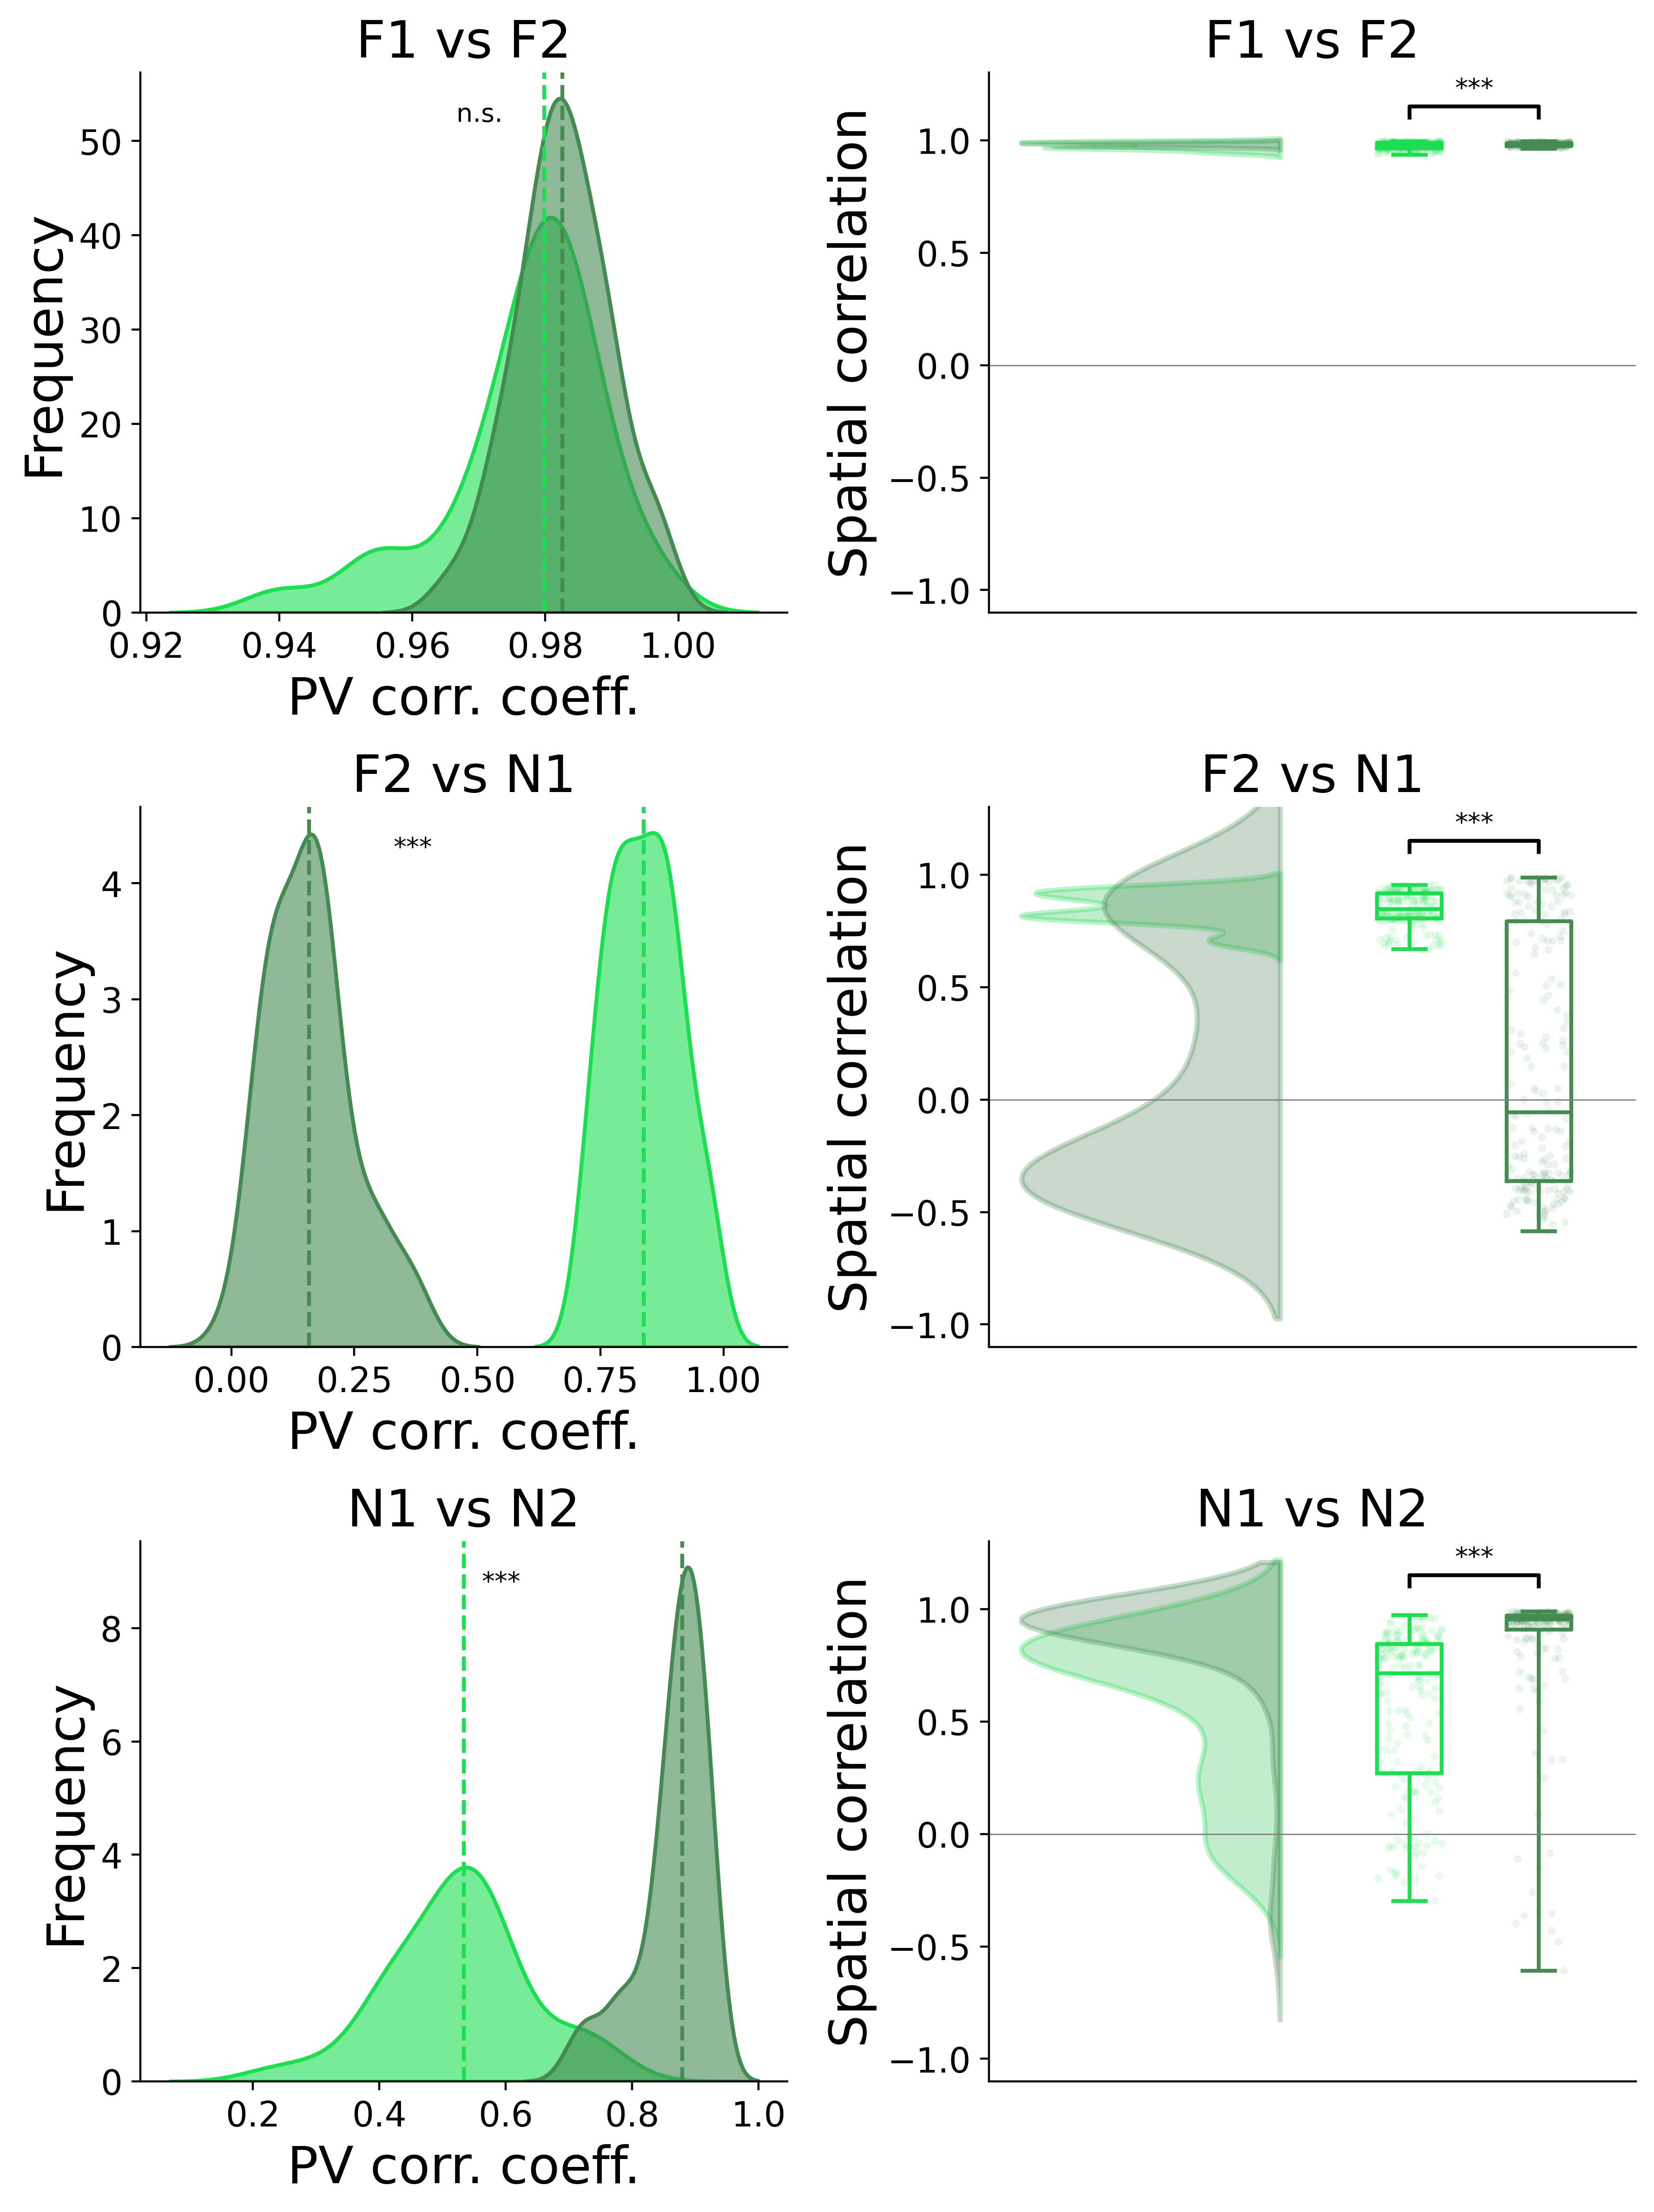

In [2]:
### plot PV and Spatial Correlations and compute statistics

with open(f"simulations/data/1d_2envs/act_maps_and_pvs_inh_normal.pkl", 'rb') as f:
    act_maps_and_pvs = pickle.load(f)

pvs_per_condition = act_maps_and_pvs['pvs_per_condition']
all_act_maps = act_maps_and_pvs['all_act_maps']
sp_per_condition = act_maps_and_pvs['sp_per_condition']

p_vals = []

for j, measure in enumerate([pvs_per_condition, sp_per_condition]):
    print(f"Results for {'pv' if j == 0 else 'spatial'} correlations")
    for i, comp in enumerate([('F1', 'F2'), ('F2', 'N1'), ('N1', 'N2')]):
        data1, data2 = measure['exp'][i], measure['control'][i]
        print('Exp M = ', np.mean(data1), 'SD = ', np.std(data1), 'Control M = ', np.mean(data2), 'SD = ', np.std(data2))
        stat, p = ks_2samp(data1, data2)
        was_d = wasserstein_distance(data1, data2)
        p_vals.append(p)
        print(f"KS test for {comp[0]} vs {comp[1]}: stat={stat}, p={p}, wasserstein distance={was_d}")

p_vals = multipletests(p_vals, method='fdr_bh')[1]  # Adjust p-values for multiple comparisons

fig, axs = plt.subplots(3, 2, figsize=(9, 12), dpi=400) 

for j, measure in enumerate([pvs_per_condition, sp_per_condition]):
    print(f"Results for {'pv' if j == 0 else 'spatial'} correlations")
    for i, comp in enumerate([('F1', 'F2'), ('F2', 'N1'), ('N1', 'N2')]):
        data1, data2 = measure['exp'][i], measure['control'][i]
        stat, _ = ks_2samp(data1, data2)
        was_d = wasserstein_distance(data1, data2)
        p = p_vals[j*3+i]
        if j == 0:
            plot_pv_corr_distributions((data1, data2), comp[0], comp[1], axs[i, j], p=(p,),
                                        colors=(COLOR_SETTINGS['exp_normal'], COLOR_SETTINGS['control_normal']))
        else:
            create_raincloud_plot((data1, data2), comp[0], comp[1], axs[i, j], p=(p,),
                                    colors=(COLOR_SETTINGS['exp_normal'], COLOR_SETTINGS['control_normal']))
            
        print(f"KS test for {comp[0]} vs {comp[1]}: stat={stat}, p={p}, wasserstein distance={was_d}")

plt.tight_layout()
plt.show()
plt.close()


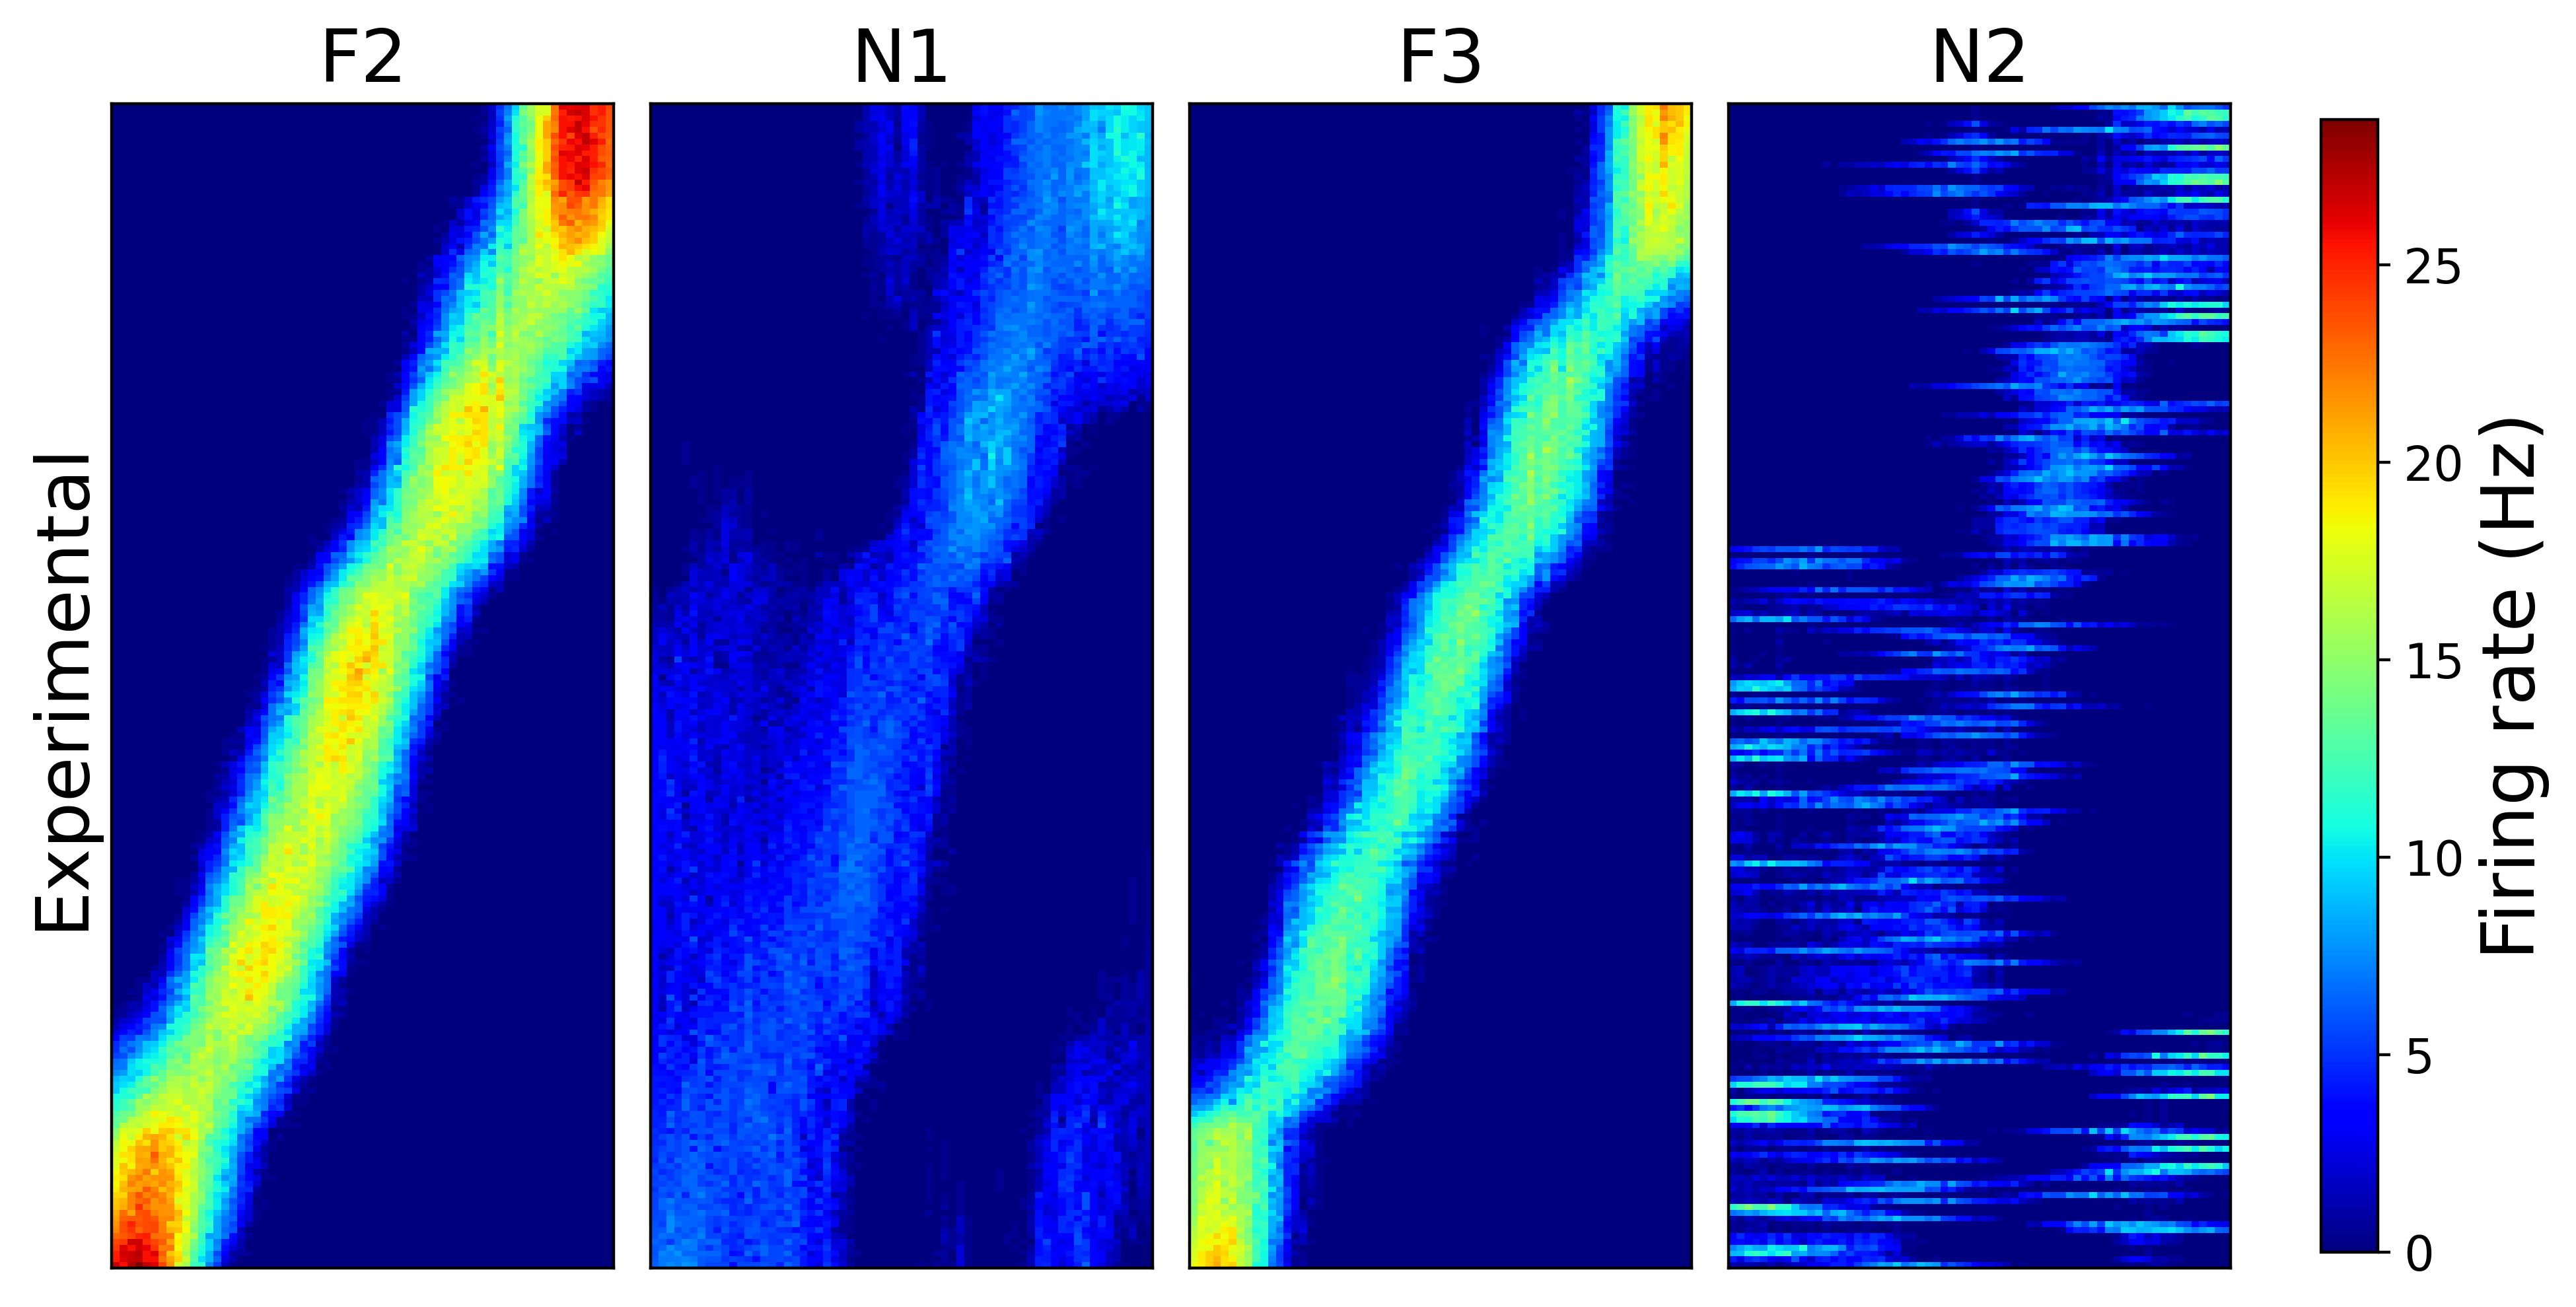

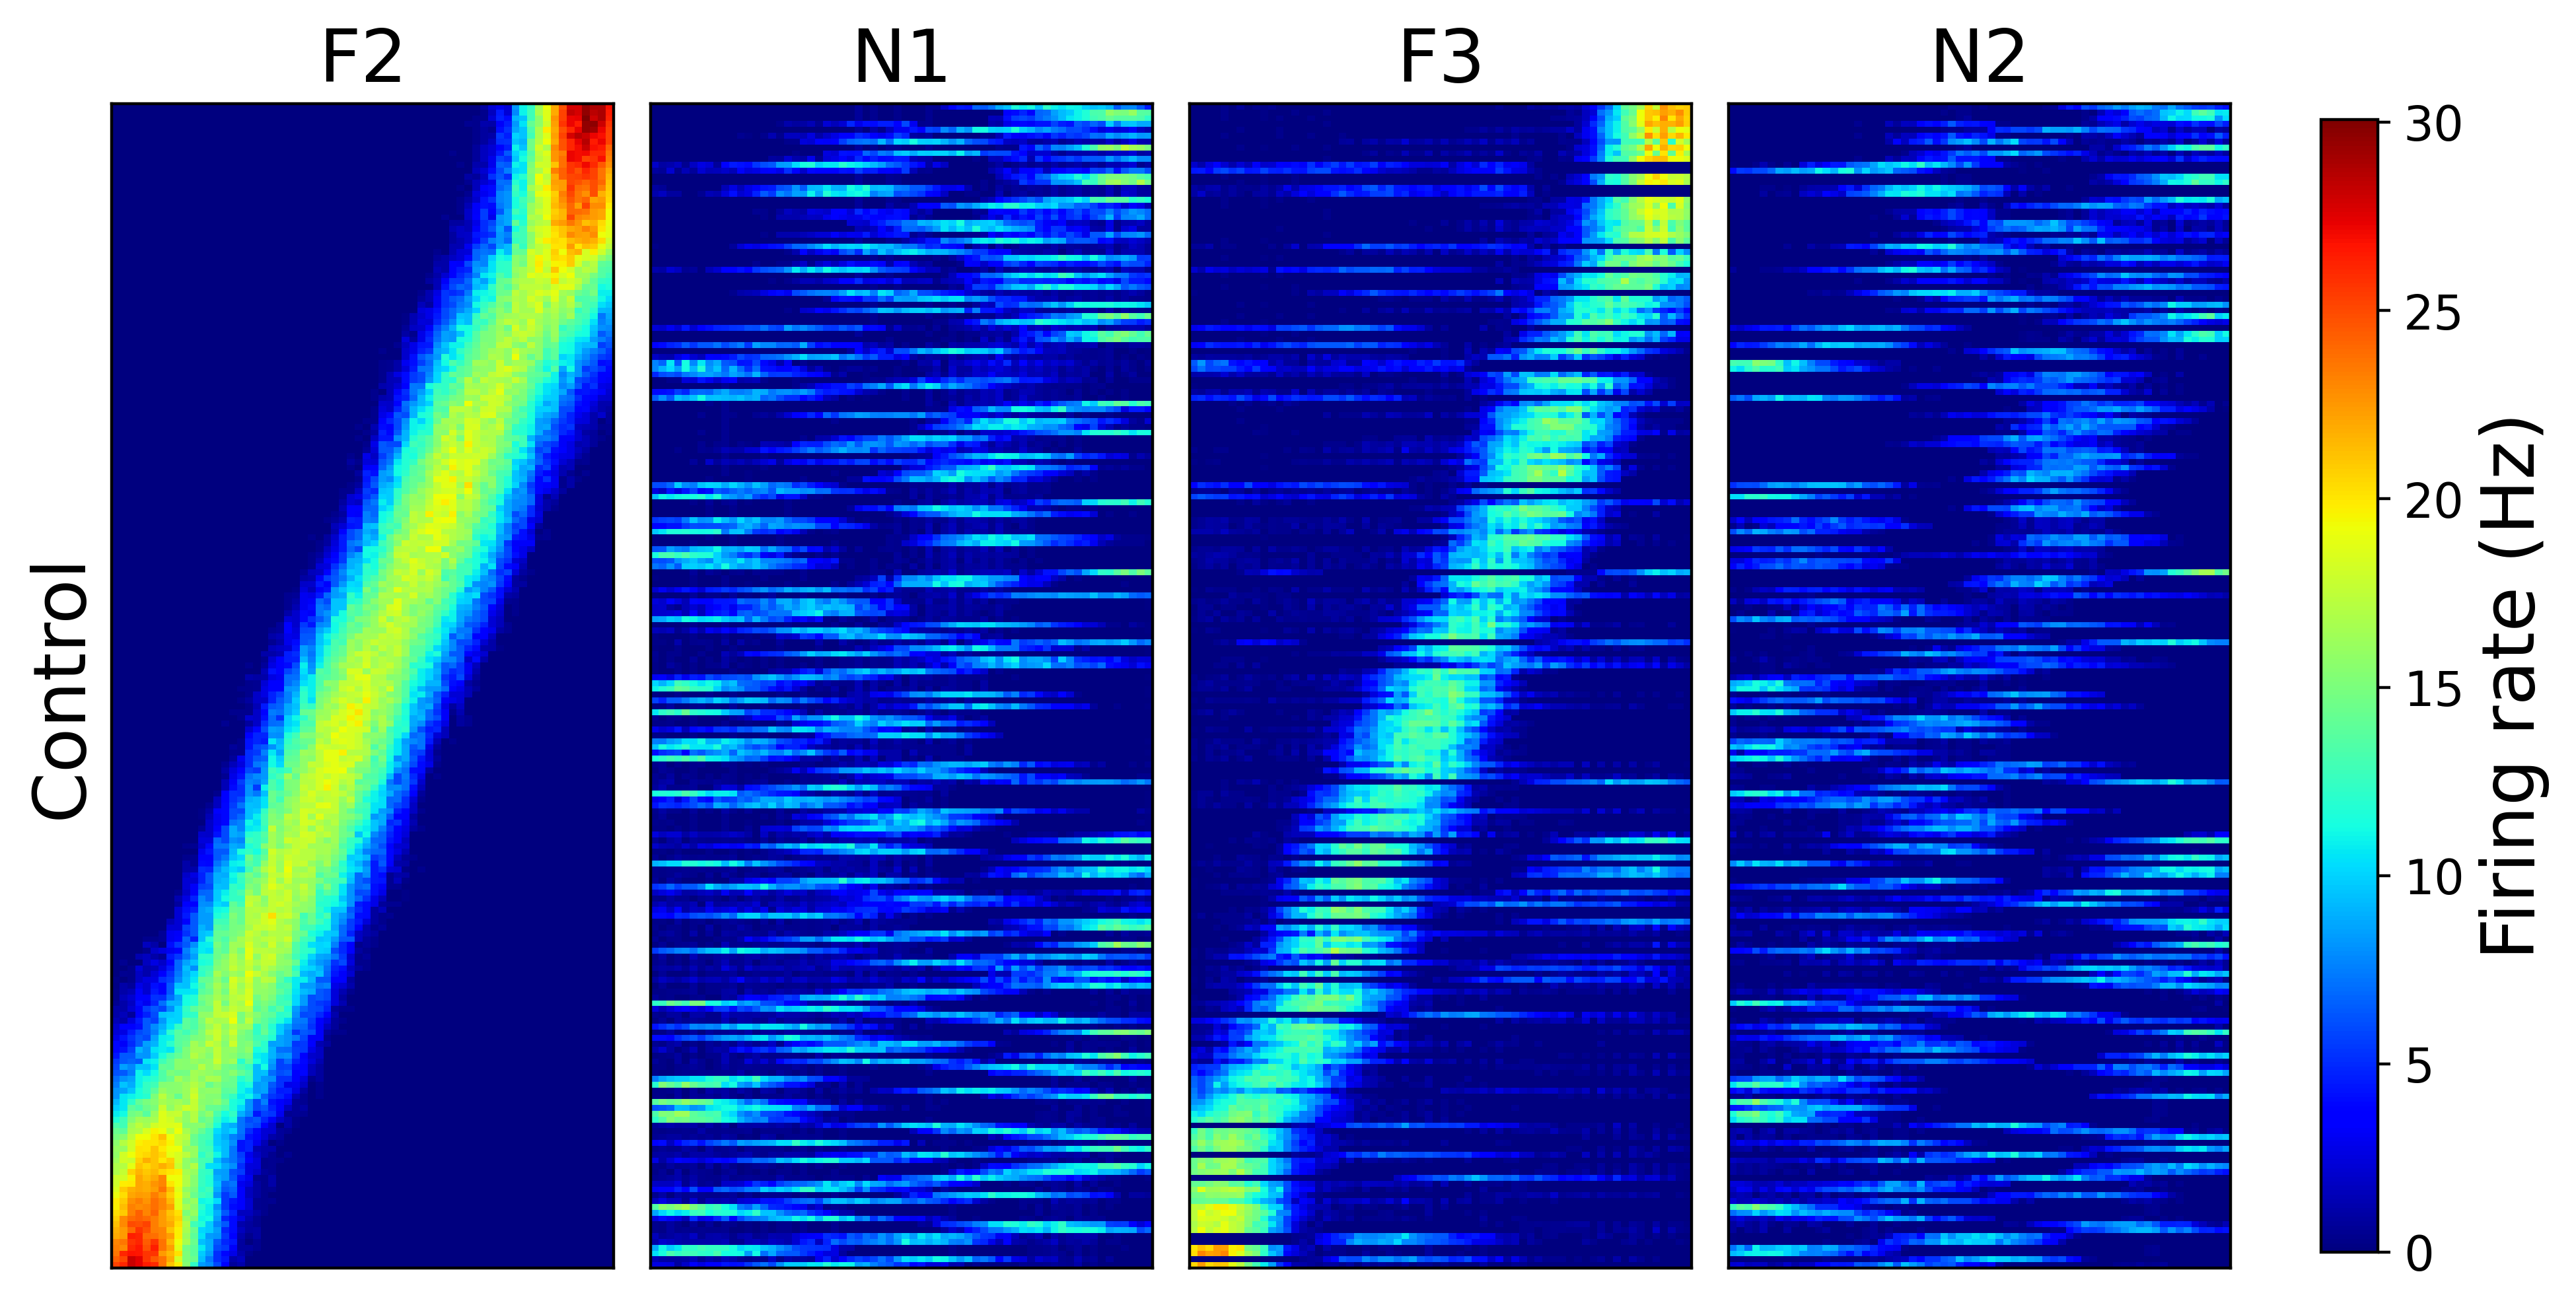

In [3]:
### plot activity maps over conditions and stages

for condition in ['exp', 'control']:
    plot_condition(all_act_maps[condition], "Experimental" if condition == 'exp' else "Control")

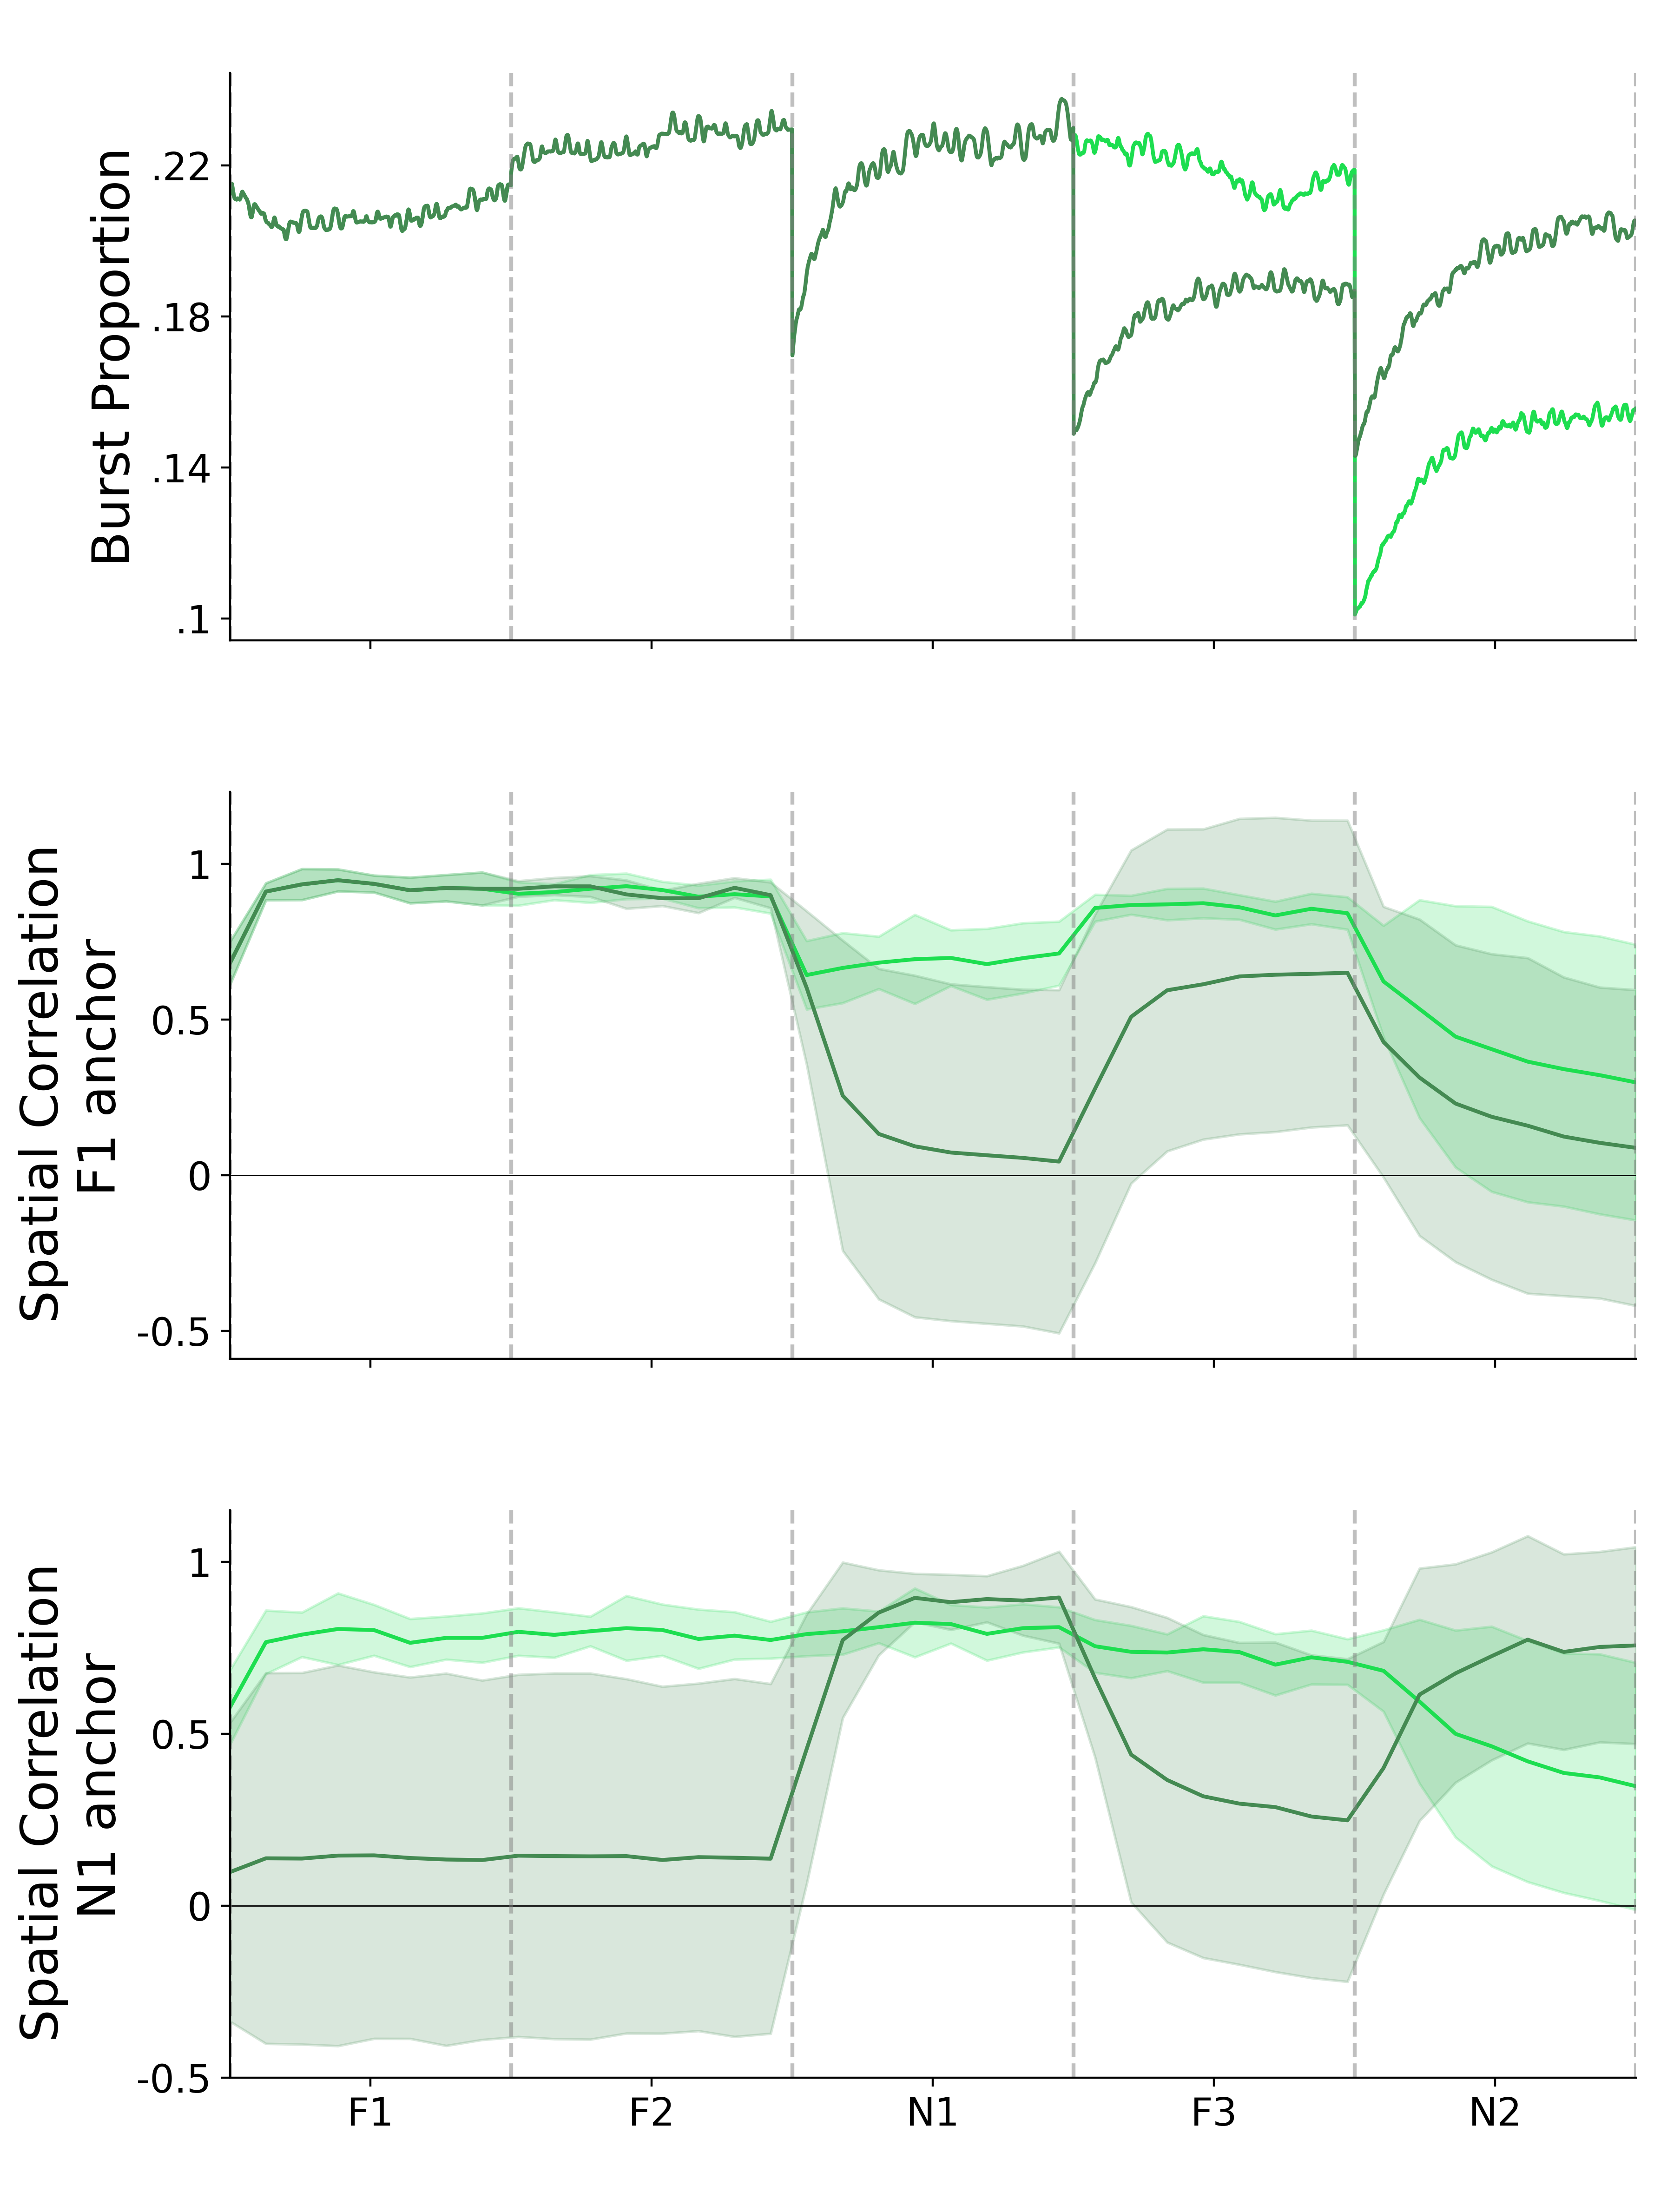

In [4]:
### Plot change in burst proportions and anchor correlations over time

tn = TN_1D*5 # 5 trials

with open(f"simulations/data/1d_2envs/act_maps_and_pvs_inh_normal.pkl", 'rb') as f:
    act_maps_and_pvs = pickle.load(f)

brs = act_maps_and_pvs['all_brs']
frs = act_maps_and_pvs['all_frs']

all_act_maps = act_maps_and_pvs['all_act_maps']
all_act_maps_split = act_maps_and_pvs['all_act_maps_split']

burst_props = compute_burst_props(brs, frs, window= 200)
all_cors = compute_cors_time_series(all_act_maps, all_act_maps_split)

fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=True, dpi=400)

plot_burst_props(burst_props, tn, ax=axs[0])
plot_cor_time_series(all_cors, tn, axs[1:])

cuts = np.linspace(0, 1, 6) * tn

for ax in axs: 
    if ax != axs[0]:
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    for cut in cuts:
        ax.axvline(x=cut, color='gray', linestyle='--', alpha=0.5)  # Vertical line for each trial cut
    sns.despine(ax=ax, top=True, right=True)
    ax.set_title(' ', fontsize=20)  # Set title to empty string for spacing
    ax.set_xlabel(' ', fontsize=20)  # Set xlabel to empty string for spacing

axs[2].set_xticks(
    cuts - cuts[1]/2
)
axs[2].set_xticklabels(['', 'F1', 'F2', 'N1', 'F3', 'N2'], rotation=0, fontsize=15)
plt.xticks(fontsize=15)

axs[2].set_xlim([0, cuts[-1]])
plt.tight_layout()
plt.show()

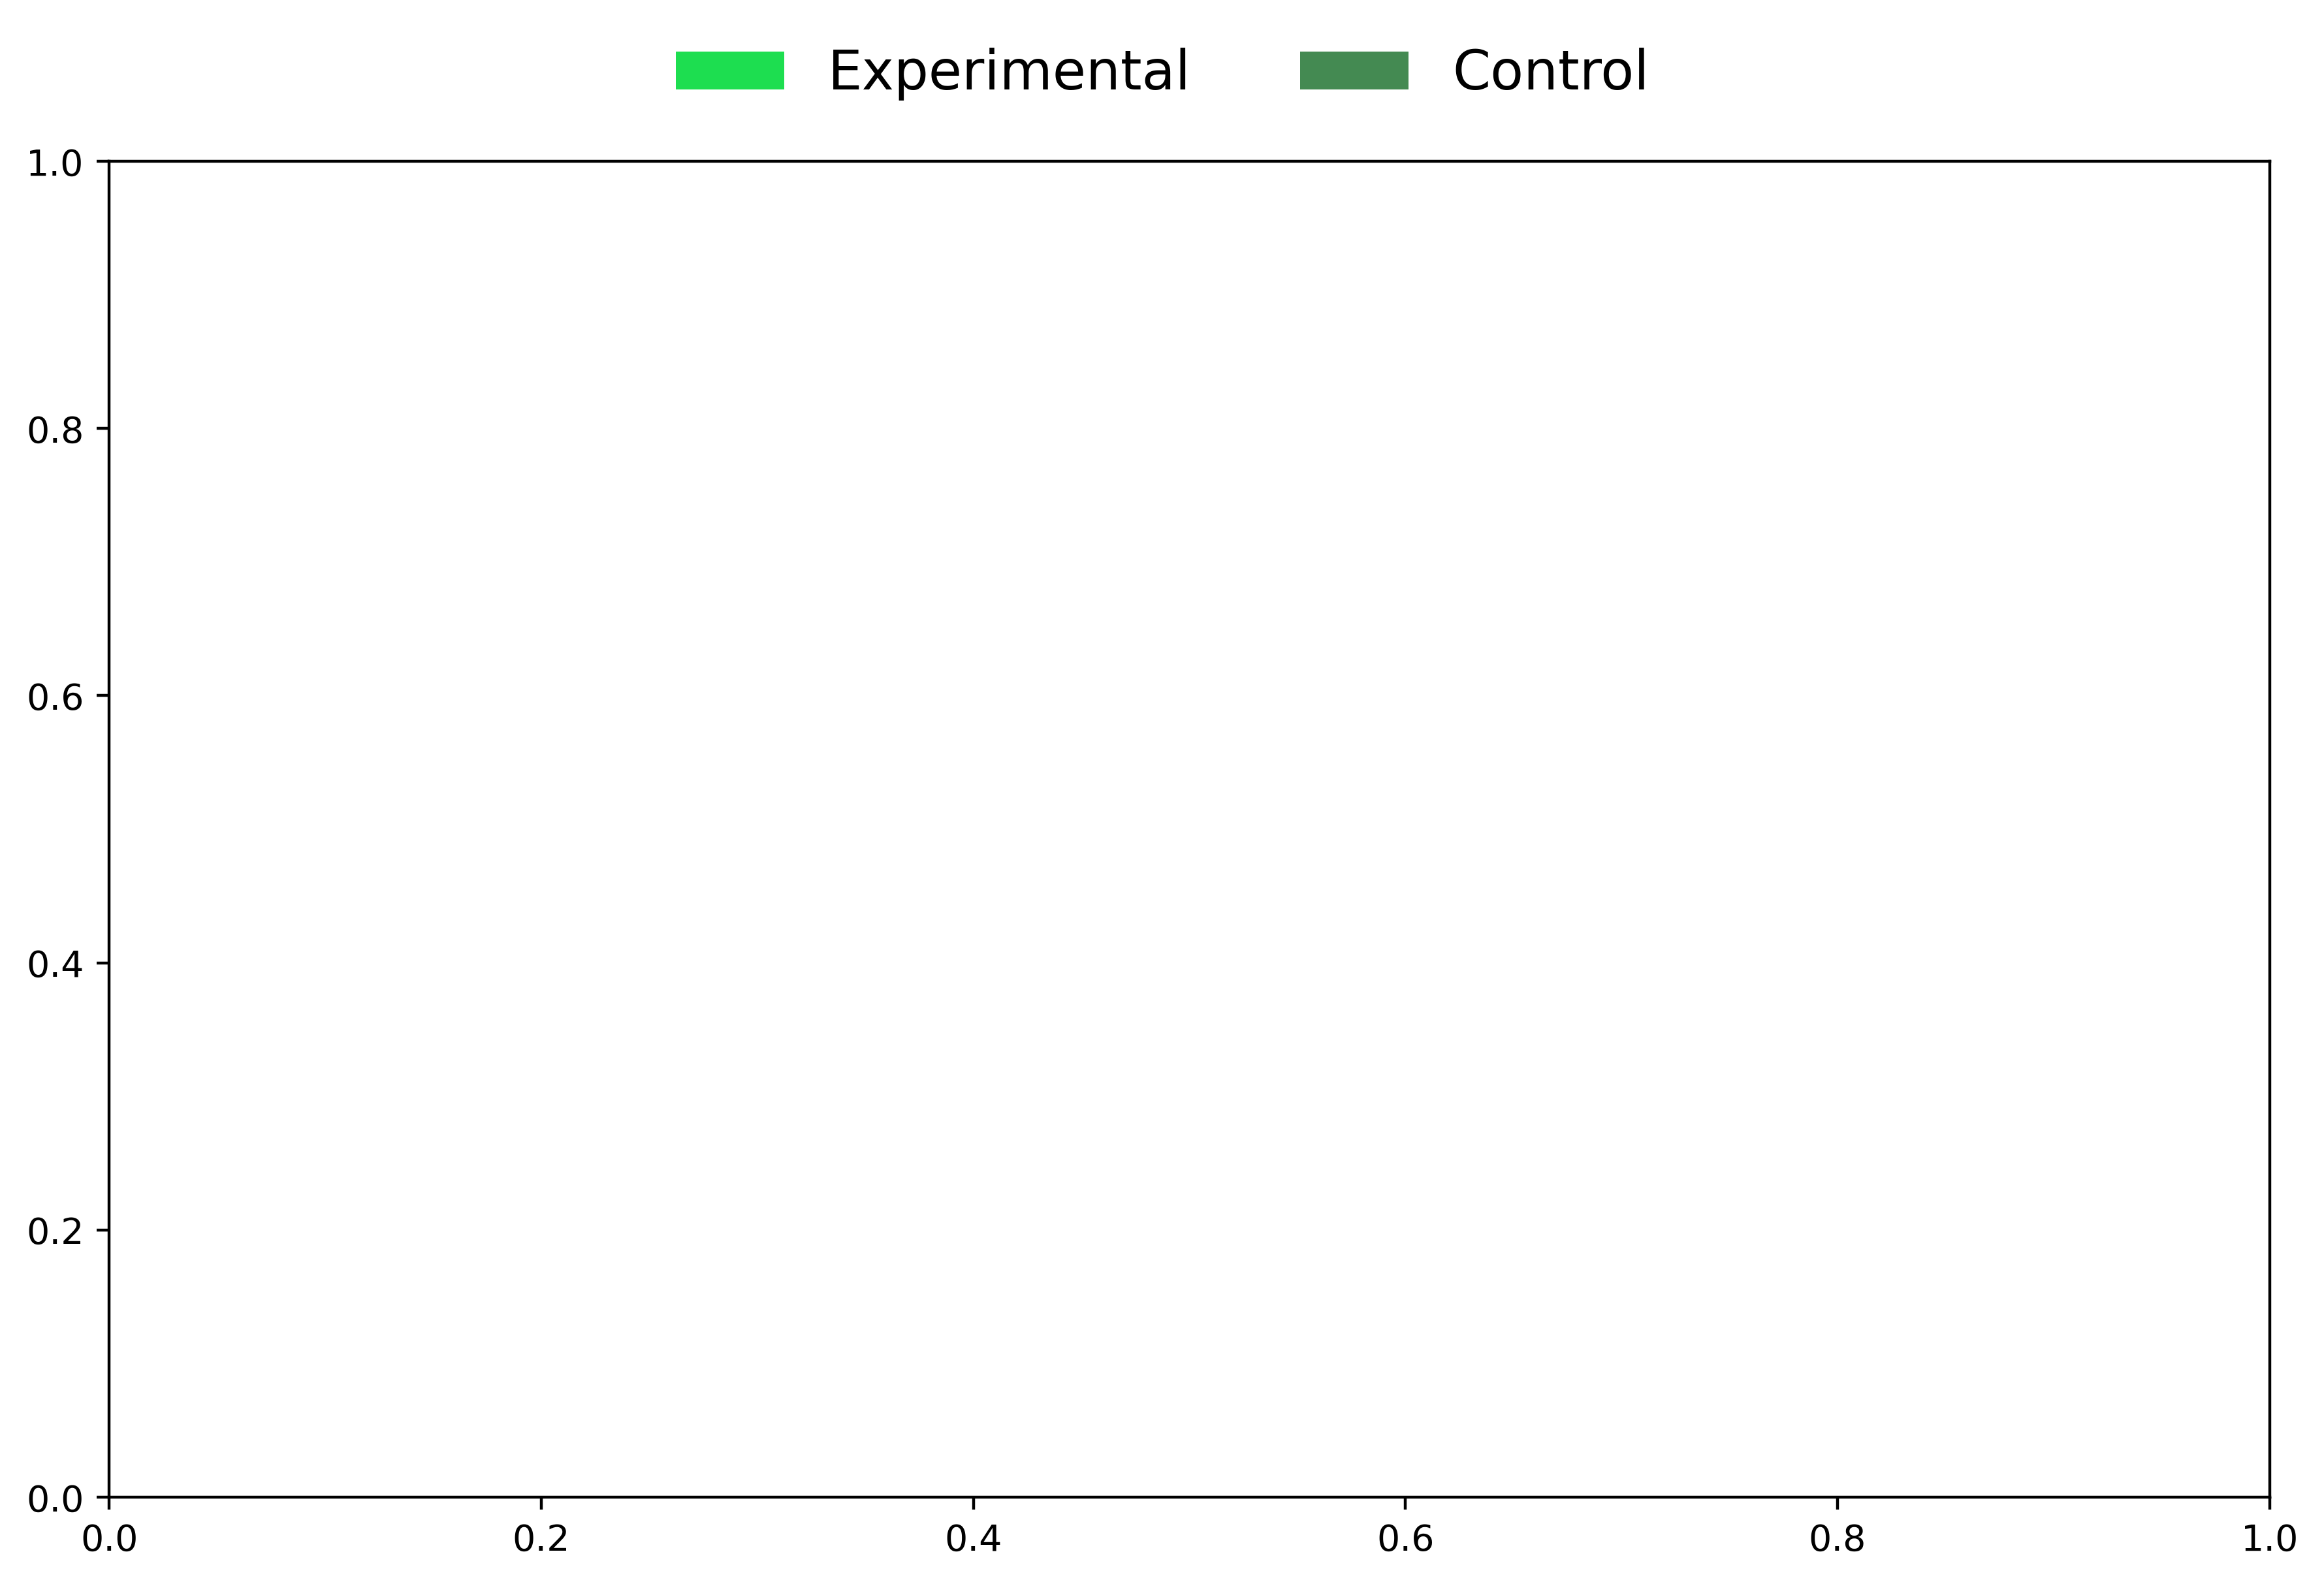

In [5]:
### dummy plot for legend labels of experimental groups

fig, ax = plt.subplots(figsize=(9, 6), dpi=400)

# Create shared legend
legend_elements = [
    Patch(facecolor=COLOR_SETTINGS['exp_normal'], label='Experimental'),
    Patch(facecolor=COLOR_SETTINGS['control_normal'], label='Control')
]

fig.legend(
    handles=legend_elements,
    title="",
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=15,
    title_fontsize=20,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at top for the legend
plt.show()
